## Regional Analysis

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import fsspec
from rasterio.plot import show
import spei as si
import pandas as pd
import spyndex

In [3]:
def plot_time_series(mask, var_ds, var_name, y_label, x_label1,x_title1, x_label2,x_title2):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

    region_1 = var_ds.where(mask==1, other=np.nan)[var_name].mean(dim=('lon', 'lat'))
    region_2 = var_ds.where(mask==2, other=np.nan)[var_name].mean(dim=('lon', 'lat'))
    region_3 = var_ds.where(mask==3, other=np.nan)[var_name].mean(dim=('lon', 'lat'))

    x = var_ds.time
    plot_3regions(x, ax1, region_1, region_2, region_3)
    ax1.set_xlabel(x_label1)
    ax1.set_ylabel(y_label)
    ax1.set_title(x_title1)
    ax1.legend()

    summer_months = var_ds.sel(time=var_ds.time.dt.month.isin([7,8,9,10])).resample(time="YS").mean()
    region_1 = summer_months.where(mask==1, other=np.nan)[var_name].mean(dim=('lon', 'lat'))
    region_2 = summer_months.where(mask==2, other=np.nan)[var_name].mean(dim=('lon', 'lat'))
    region_3 = summer_months.where(mask==3, other=np.nan)[var_name].mean(dim=('lon', 'lat'))

    x=summer_months.time
    plot_3regions(x, ax2, region_1, region_2, region_3)
    ax2.set_xlabel(x_label2)
    ax2.set_ylabel(y_label)
    ax2.set_title(x_title2)

def plot_3regions(time, axis, region_1, region_2, region_3):
    x=time
    axis.plot(x, region_3, marker='o', label="Frankenwald", color="#fde725")
    axis.plot(x, region_2, marker='o', label="Thüringer Schiefergebirge", color="#21918c")
    axis.plot(x, region_1, marker='o', label="Thüringer Wald", color="#440154")

#### Regions masks



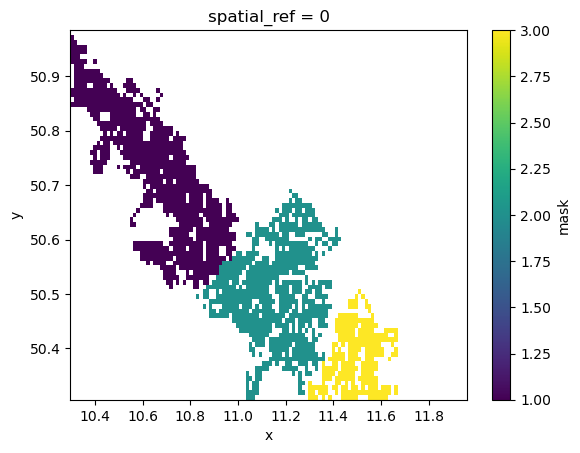

In [4]:
import zarr
path = '/work/users/my982hzao/'
sm_masked = xr.open_zarr(fsspec.get_mapper(path + 'Climate_variables/temperature_masked.zarr/'),
                  consolidated=True)

mask = sm_masked["mask"]
mask = mask.rename({"lon": "x", "lat": "y"})
mask.rio.write_crs("EPSG:4326", inplace=True)
mask.plot()

#### 1.Remote Sensing Indices

In [5]:
# define indices to be calculated
index_list =  [ "NDVI","BaI", "GVMI", "NDMI" ]

# get indices description
attrs_dict = {}
for index in index_list:
    attrs_dict[str(index)] = str(spyndex.indices[index])

# calculate indices for each masked ds
def calculate_rs_indices(ds):

    A = ds.refl.sel(band=1) / 1e5
    B = ds.refl.sel(band=2) / 1e5
    G = ds.refl.sel(band=3)/ 1e5
    R = ds.refl.sel(band=4)/ 1e5
    RE1 = ds.refl.sel(band=5)/ 1e5
    RE2 = ds.refl.sel(band=6)/ 1e5
    RE3 = ds.refl.sel(band=7)/ 1e5
    N = ds.refl.sel(band=8)/ 1e5
    N2 = ds.refl.sel(band=9)/ 1e5
    WV = ds.refl.sel(band=10)/ 1e5
    S1 = ds.refl.sel(band=11)/ 1e5
    S2 = ds.refl.sel(band=12)/ 1e5

    param_dict = { "A" : A, "B" : B, "G" : G, "R" : R, "RE1" : RE1, "RE2" : RE2, "RE3" : RE3, "N" : N, "N2" : N2, "WV" : WV, "S1" : S1, "S2" : S2, "L" : 0.5, "gamma" : 1, "nexp" : 2,
    }

    for index in index_list:
        attrs_dict[str(index)] = str(spyndex.indices[index])

    idx = spyndex.computeIndex(
    index = index_list,
    params = param_dict)

    return idx

def plot_Index(index_name, index_no, time, indices_thur_wald, indices_thur_sch, indices_franwald):
    print(attrs_dict[index_name])
    fig, ax1 = plt.subplots(1, 1, figsize=(14, 4))
    plot_3regions(time, ax1, indices_thur_wald.isel(index=index_no), indices_thur_sch.isel(index=index_no), indices_franwald.isel(index=index_no))
    ax1.set_xlabel(index_name)
    ax1.set_ylabel("reflectance")
    ax1.set_title(index_name)
    ax1.legend()
    return

In [6]:
ds_CF_20 = xr.open_zarr(fsspec.get_mapper(path + 'S2_Frankenwald_CF_20.zarr'), \
                  consolidated=True)

mask_s2 = ds_CF_20["forest_region"]

franwald =ds_CF_20.where(mask_s2==3)
thur_sch =ds_CF_20.where(mask_s2==2)
thur_wald =ds_CF_20.where(mask_s2==1)

indices_franwald = calculate_rs_indices(franwald).mean(dim = ['lat', 'lon'])
indices_thur_sch = calculate_rs_indices(thur_sch).mean(dim = ['lat', 'lon'])
indices_thur_wald = calculate_rs_indices(thur_wald).mean(dim = ['lat', 'lon'])

##### a. NDVI

NDVI: Normalized Difference Vegetation Index
        * Application Domain: vegetation
        * Bands/Parameters: ['N', 'R']
        * Formula: (N-R)/(N+R)
        * Reference: https://ntrs.nasa.gov/citations/19740022614
        


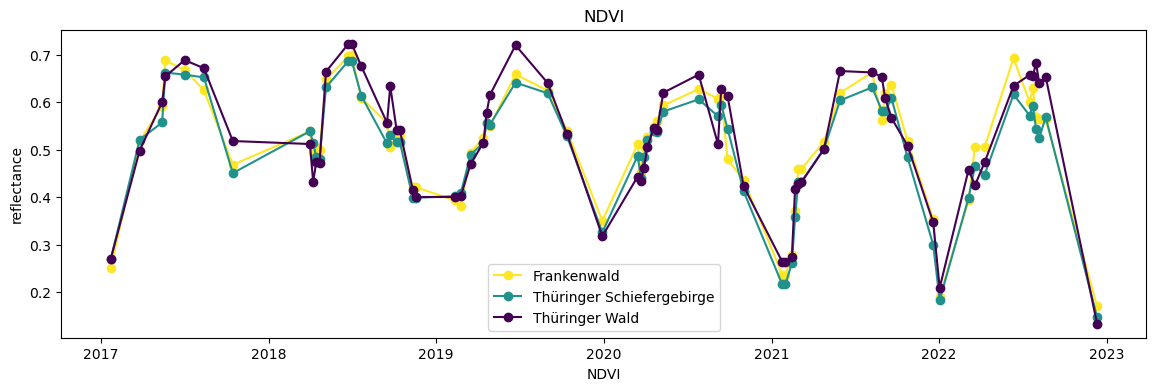

In [7]:
plot_Index("NDVI", 0, ds_CF_20.time, indices_thur_wald, indices_thur_sch, indices_franwald)

##### b. BaI

BaI: Bareness Index
        * Application Domain: soil
        * Bands/Parameters: ['R', 'S1', 'N']
        * Formula: R+S1-N
        * Reference: https://doi.org/10.1109/IGARSS.2005.1525743
        


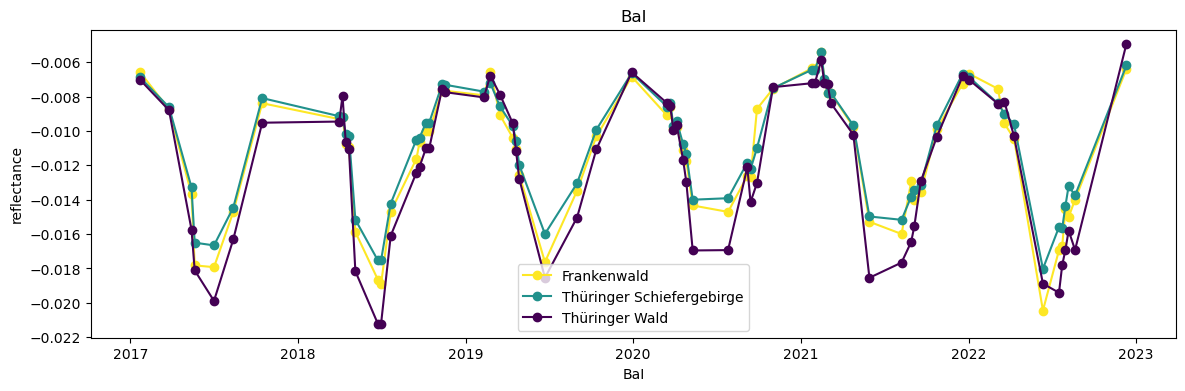

In [8]:
plot_Index("BaI", 1, ds_CF_20.time, indices_thur_wald, indices_thur_sch, indices_franwald)

#####  c. GVMI

GVMI: Global Vegetation Moisture Index
        * Application Domain: vegetation
        * Bands/Parameters: ['N', 'S2']
        * Formula: ((N+0.1)-(S2+0.02))/((N+0.1)+(S2+0.02))
        * Reference: https://doi.org/10.1016/S0034-4257(02)00037-8
        


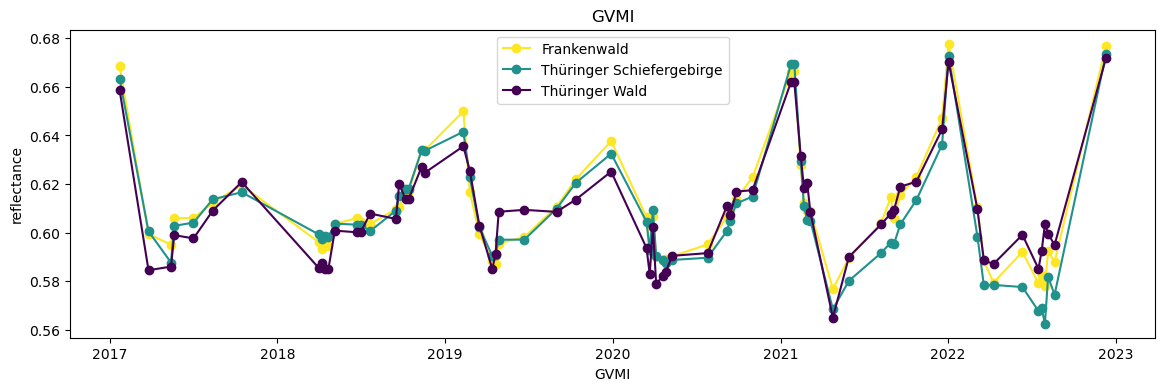

In [9]:
plot_Index("GVMI", 2, ds_CF_20.time, indices_thur_wald, indices_thur_sch, indices_franwald)

##### d. NDMI

NDMI: Normalized Difference Moisture Index
        * Application Domain: vegetation
        * Bands/Parameters: ['N', 'S1']
        * Formula: (N-S1)/(N+S1)
        * Reference: https://doi.org/10.1016/S0034-4257(01)00318-2
        


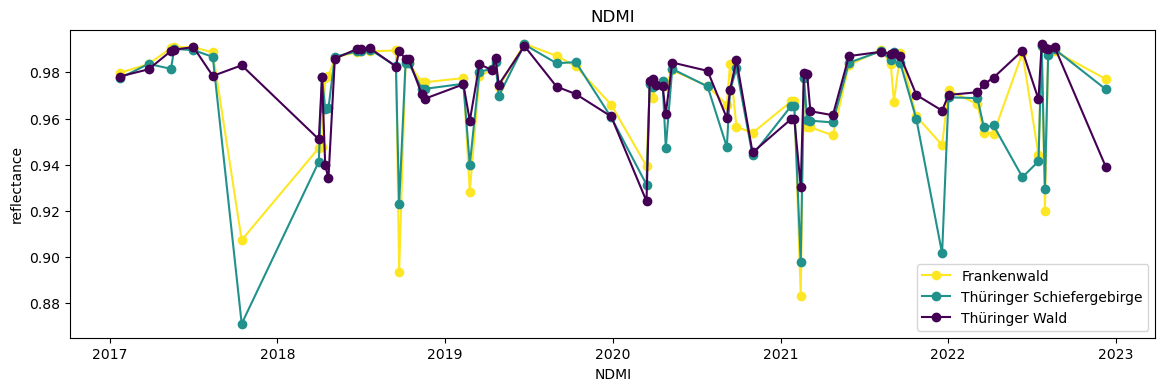

In [10]:
plot_Index("NDMI", 3, ds_CF_20.time, indices_thur_wald, indices_thur_sch, indices_franwald)

#### 2. Climate Variables 
##### a. Temperature

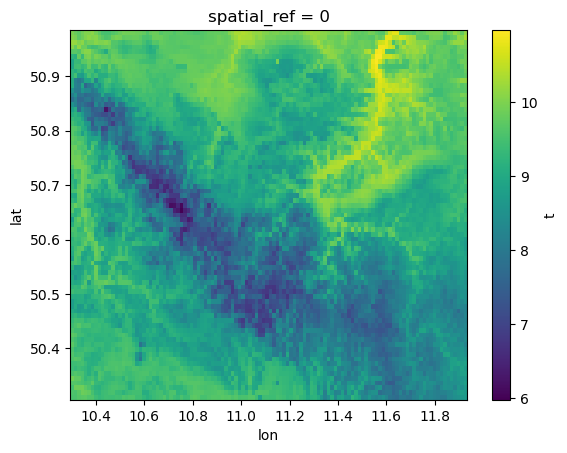

In [11]:
temp_ds = xr.open_zarr(fsspec.get_mapper(path + 'temperature_UTM.zarr/'), consolidated=True)
temp_utm = temp_ds
temp_utm.rio.write_crs("EPSG:4326", inplace=True)
mask_reprojected_temp = mask.rio.reproject_match(temp_utm.rename({"lon": "x", "lat": "y"})).rename({"x": "lon", "y": "lat"})

temp_utm = temp_utm*0.1
temp_mean = temp_utm.t.mean(dim='time')
temp_mean.plot()

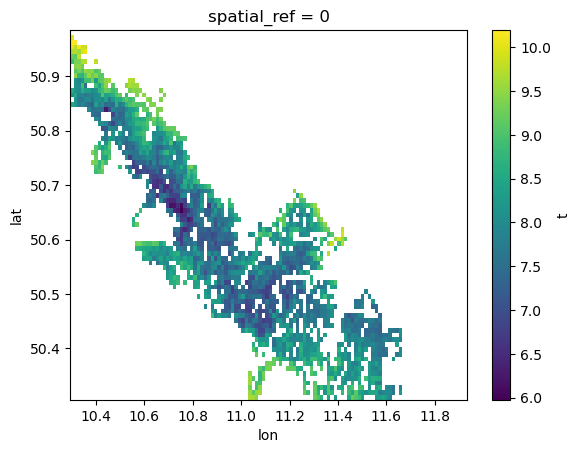

In [12]:
temp_mean.where(mask_reprojected_temp<4).plot()

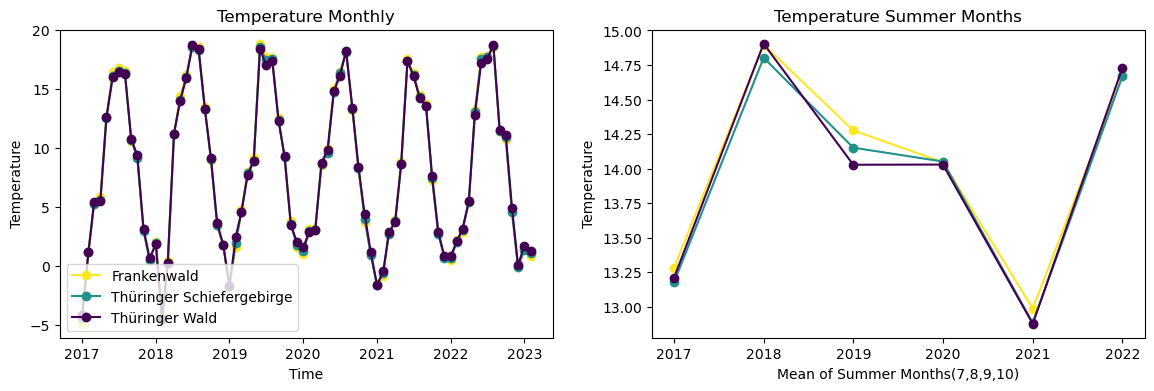

In [13]:
plot_time_series(mask_reprojected_temp, temp_utm, "t", "Temperature","Time",'Temperature Monthly',"Mean of Summer Months(7,8,9,10)", 'Temperature Summer Months')

##### b. Soil Moisture

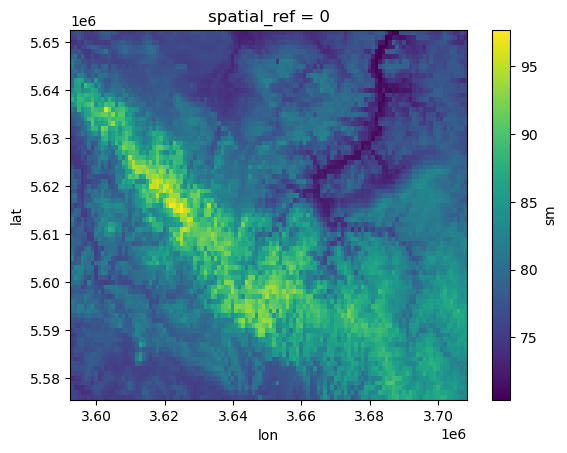

In [28]:
sm_ds = xr.open_zarr(fsspec.get_mapper(path + 'soil_moisture_monthly_UTM_4.zarr/'), consolidated=True)
sm_utm = sm_ds
sm_utm.rio.write_crs("EPSG:31467", inplace=True)
mask_reprojected_sm = mask.rio.reproject_match(sm_utm.rename({"lon": "x", "lat": "y"})).rename({"x": "lon", "y": "lat"})

sm_utm.sm.mean(dim='time').plot()

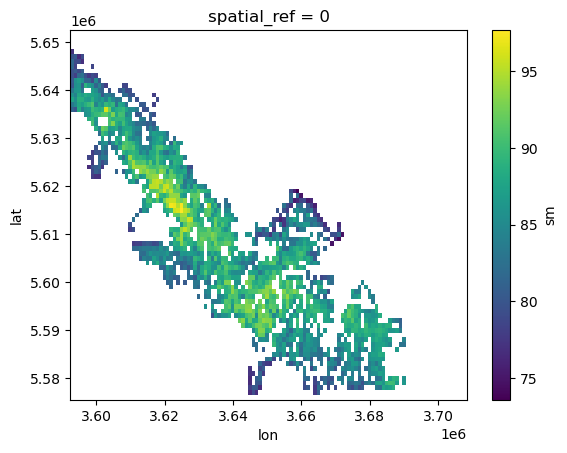

In [29]:
sm_utm.sm.mean(dim='time').where(mask_reprojected_sm<4).plot()

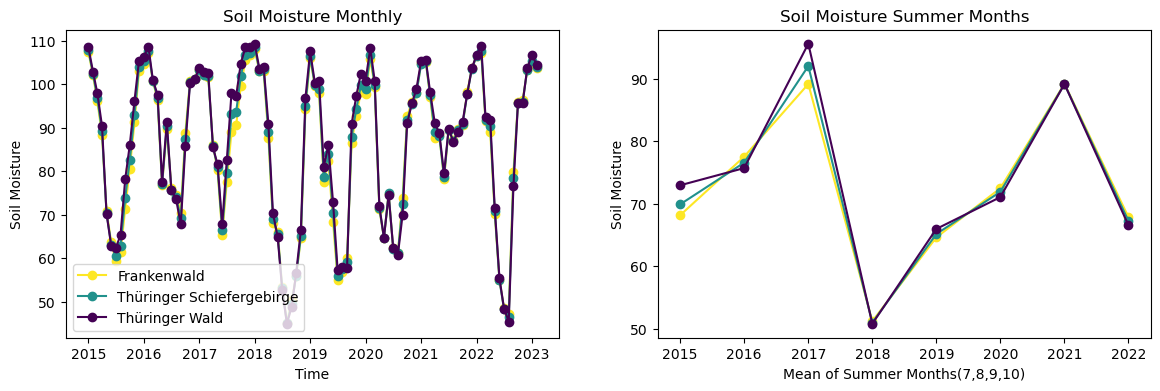

In [30]:
plot_time_series(mask_reprojected_sm, sm_ds, "sm", "Soil Moisture","Time",'Soil Moisture Monthly',"Mean of Summer Months(7,8,9,10)", 'Soil Moisture Summer Months')


##### c. Precipitation 

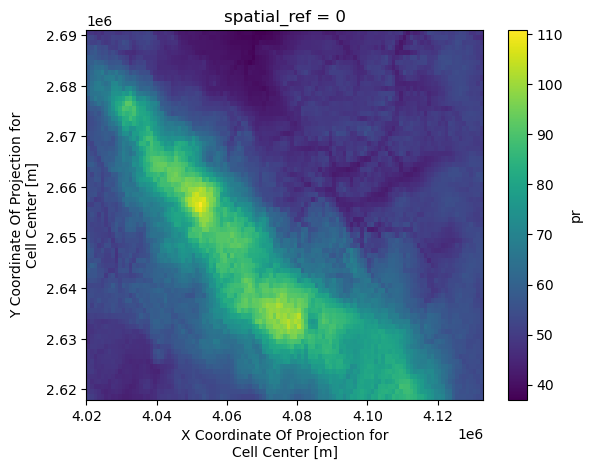

In [17]:
pr_ds = xr.open_dataset(path + 'SPEI/pr_rec.nc/', engine='netcdf4')
pr_ds.rio.write_crs("EPSG:3034", inplace=True)

mask_SPEI = mask
mask_SPEI.rio.write_crs("EPSG:4326", inplace=True)
mask_SPEI = mask.rio.reproject_match(pr_ds.rename({"lon": "x", "lat": "y"})).rename({"x": "lon", "y": "lat"})

pr_ds.pr.mean(dim='time').plot()

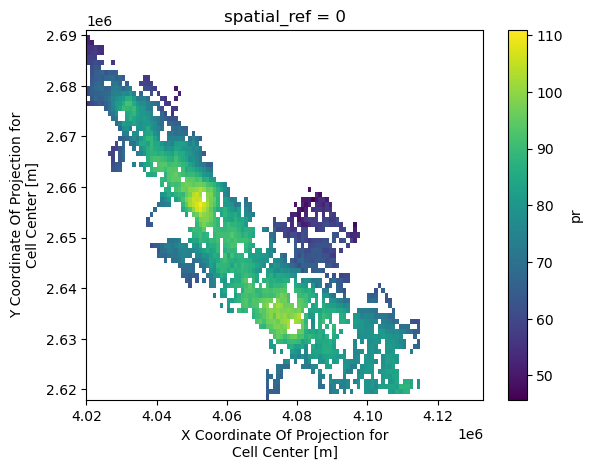

In [18]:
pr_ds.pr.mean(dim='time').where(mask_SPEI<4).plot()

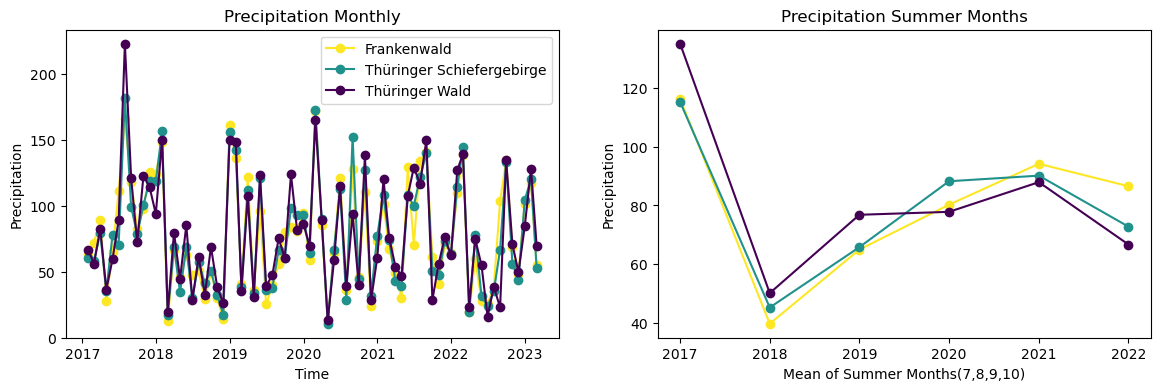

In [19]:
plot_time_series(mask_SPEI, pr_ds, "pr","Precipitation","Time",'Precipitation Monthly',"Mean of Summer Months(7,8,9,10)", 'Precipitation Summer Months')


##### d. Evapotranspiration

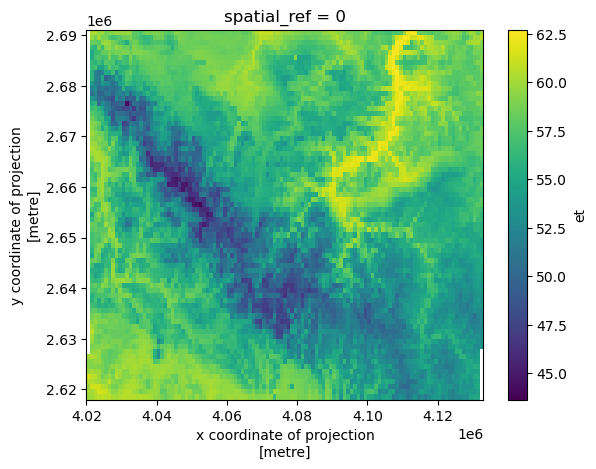

In [20]:
et_ds = xr.open_dataset(path + 'SPEI/et_rec.nc/', engine='netcdf4')
et_ds.rio.write_crs("EPSG:3034", inplace=True)
et_ds.et.mean(dim='time').plot()

/tmp/ipykernel_1239240/1088547875.py:1: UserWarning: rename 'lon' to 'lon' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  et_ds.et.mean(dim='time').where(mask_SPEI<4).rename({"lon": "lon", "lat": "lat"}).plot()
/tmp/ipykernel_1239240/1088547875.py:1: UserWarning: rename 'lat' to 'lat' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  et_ds.et.mean(dim='time').where(mask_SPEI<4).rename({"lon": "lon", "lat": "lat"}).plot()


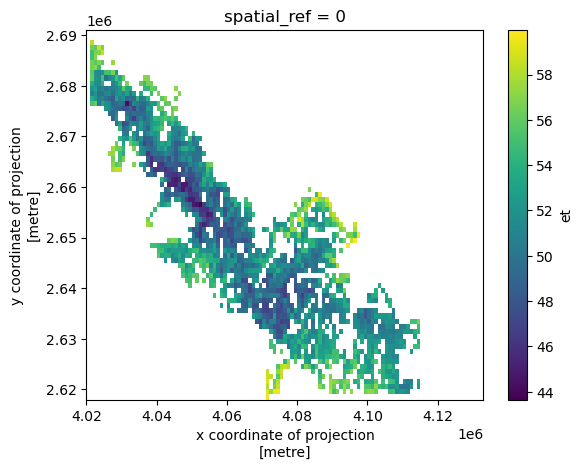

In [21]:
et_ds.et.mean(dim='time').where(mask_SPEI<4).rename({"lon": "lon", "lat": "lat"}).plot()

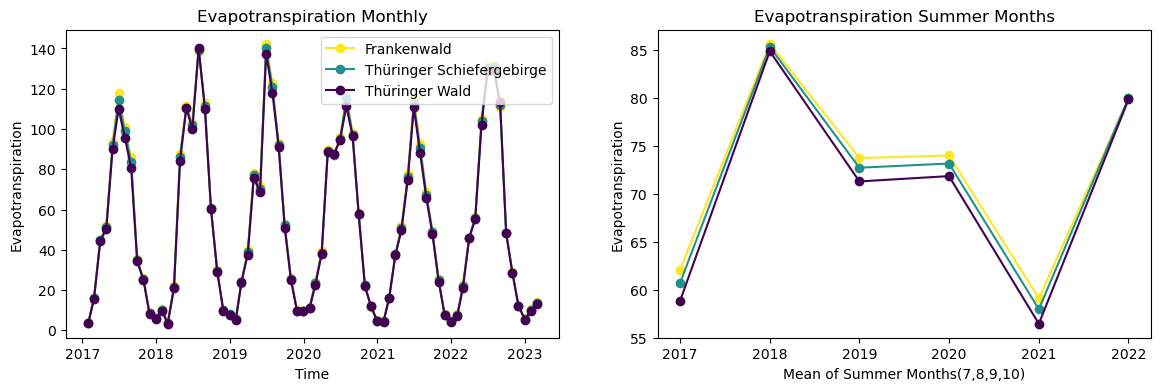

In [22]:
plot_time_series(mask_SPEI, et_ds, "et","Evapotranspiration","Time",'Evapotranspiration Monthly',"Mean of Summer Months(7,8,9,10)", 'Evapotranspiration Summer Months')

#### 3. Drought Indices

In [23]:
import scipy.stats as scs
def Calculate_SPI(pr_monthly, region_no,mask):
    pr = xarray_to_df(pr_monthly, region_no, mask)
    spi = si.spi(pr.iloc[:, 0].squeeze(), dist=scs.gamma)
    return spi

def Calculate_SPEI(pr, et, region_no,mask):
    pr = xarray_to_df(pr, region_no,mask)
    et = xarray_to_df(et, region_no,mask)
    pe = pr.iloc[:, 0].squeeze() - et.iloc[:, 0].squeeze()  # calculate precipitation excess
    spei = si.spei(pe)
    return spei

def xarray_to_df(ds_monthly, region_no,mask):
    region = ds_monthly.where(mask==region_no, other=np.nan)
    region = region.mean(dim=('lon', 'lat')).to_dataframe().reset_index().groupby(['time']).mean()
    region = region.dropna()
    return region


##### a. SPI

Text(0.5, 1.0, 'SPI')

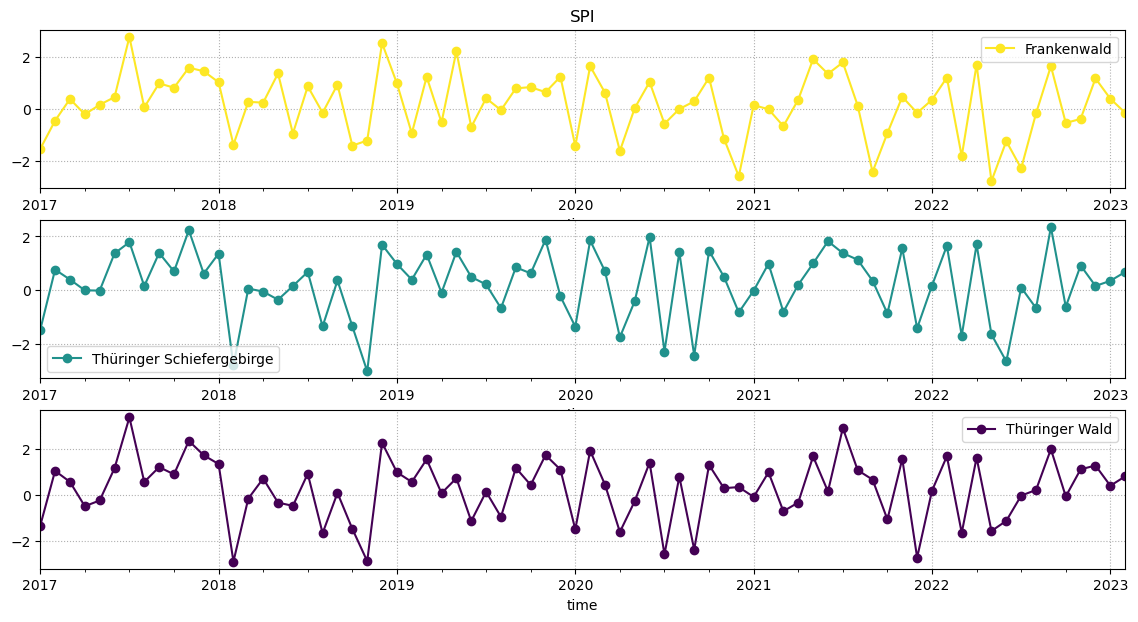

In [24]:
fig,(ax,ax2,ax3)=plt.subplots(3, 1, figsize=(14, 7))
spi1 = Calculate_SPI(pr_ds, 1, mask=mask_SPEI)
spi2 = Calculate_SPI(pr_ds, 2, mask=mask_SPEI)
spi3 = Calculate_SPI(pr_ds, 3, mask=mask_SPEI)
x =  pr_ds['time']
spi1.plot( ax=ax, marker='o', label="Frankenwald", color="#fde725", grid=True)
spi2.plot( ax=ax2, marker='o', label="Thüringer Schiefergebirge", color="#21918c", grid=True)
spi3.plot(  ax=ax3, marker='o', label="Thüringer Wald", color="#440154", grid=True)
ax.legend()
ax2.legend()
ax3.legend()
ax.grid(linestyle='dotted')
ax2.grid(linestyle='dotted')
ax3.grid(linestyle='dotted')
ax.set_title('SPI')


Text(0.5, 1.0, 'SPEI')

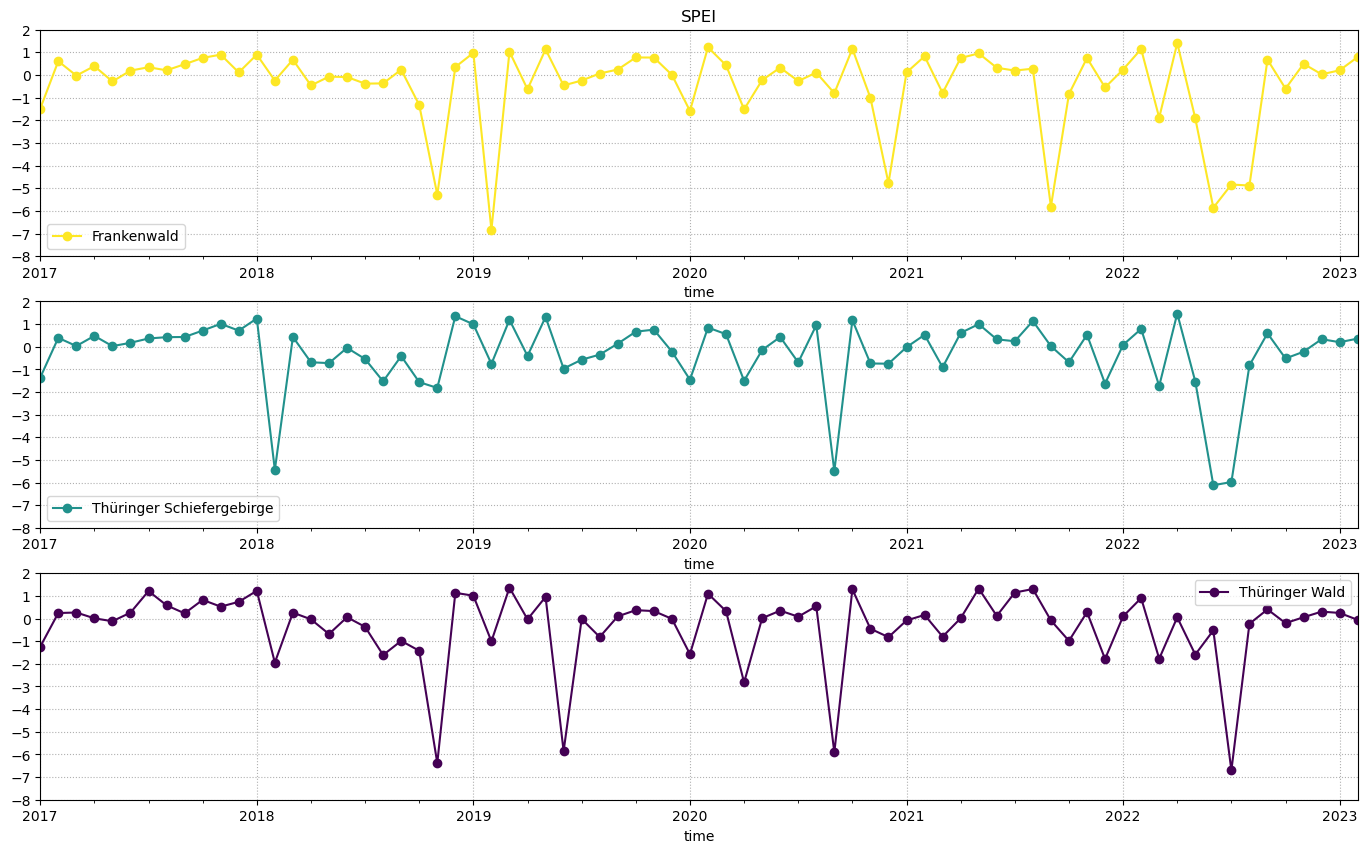

In [25]:
fig,(ax,ax2,ax3)=plt.subplots(3, 1, figsize=(17, 10))
spei1 = Calculate_SPEI(pr_ds, et_ds, 1, mask_SPEI)
spei2 = Calculate_SPEI(pr_ds, et_ds, 2, mask_SPEI)
spei3 = Calculate_SPEI(pr_ds, et_ds, 3, mask_SPEI)
x =  et_ds['time']
spei1.plot( ax=ax, marker='o', label="Frankenwald", color="#fde725", grid=True)
spei2.plot( ax=ax2, marker='o', label="Thüringer Schiefergebirge", color="#21918c", grid=True)
spei3.plot(  ax=ax3, marker='o', label="Thüringer Wald", color="#440154", grid=True)
ax.legend()
ax2.legend()
ax3.legend()
ax.set_yticks(np.arange(-8, 3, 1))
ax2.set_yticks(np.arange(-8, 3, 1))
ax3.set_yticks(np.arange(-8, 3, 1))
ax.grid(linestyle='dotted')
ax2.grid(linestyle='dotted')
ax3.grid(linestyle='dotted')
ax.set_title('SPEI')

In [26]:
# import scipy.stats as scs
# pr_monthly = pr_ds.sortby('time').rolling(time=30, center=True).sum()
# pr_monthly = pr_monthly.resample(time='1M').mean()
# pr_monthly.pr.plot()
# pr_monthly2 = pr_ds.sortby('time').resample(time='1M').sum()
# pr_monthly2.pr.plot()

